In [1]:
%cd ../..
%load_ext autoreload
%autoreload 2
%matplotlib inline

import scipy
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf, report, psth_foraging, foraging_analysis_and_export
from pipeline.plot import behavior_plot, unit_characteristic_plot, unit_psth, histology_plot, PhotostimError, foraging_plot
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice, plot_unit_all_in_one

foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol=100').proj()
import datajoint as dj; dj.conn().connect()

from statannotations.Annotator import Annotator

cache_folder = '~/s3-drive/report/st_cache/'

/root/capsule/code


[2023-03-06 19:47:58,423][INFO]: Connecting map-superuser@datajoint.mesoscale-activity-map.org:3306
[2023-03-06 19:47:58,978][INFO]: Connected map-superuser@datajoint.mesoscale-activity-map.org:3306


# Get meta info

In [2]:
foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol in (100, 110, 120)').proj()
if_photostim_from_behav = foraging_sessions.aggr(foraging_sessions * experiment.PhotostimForagingTrial, ...,
                                      keep_all_rows=True, photostim_behav='IF(COUNT(trial)>0, "yes", "no")')
if_photostim_from_ephys = foraging_sessions.aggr(foraging_sessions * (ephys.TrialEvent & 'trial_event_type LIKE "laser%"'), ...,
                                      keep_all_rows=True, photostim_NI='IF(COUNT(trial)>0, "yes", "no")')

q = ((experiment.Session & foraging_sessions)
                            * lab.WaterRestriction.proj(h2o='water_restriction_number')
                            * if_photostim_from_behav
                            * if_photostim_from_ephys
    & 'photostim_behav = "yes"').proj(..., '-rig', '-username', '-session_time')
df_sessions = pd.DataFrame(q.fetch())
photostim_behavior = df_sessions.query('photostim_behav == "yes"')
photostim_behavior

,subject_id,session,session_date,h2o,photostim_behav,photostim_NI
0,494691,19,2021-12-10,HH16,yes,no
1,494694,21,2021-12-16,HH18,yes,yes
2,494694,20,2021-12-15,HH18,yes,yes
3,494694,19,2021-12-14,HH18,yes,yes
4,494694,18,2021-12-13,HH18,yes,yes
...,...,...,...,...,...,...
86,656057,14,2023-02-16,XY_16,yes,no
87,656057,12,2023-02-14,XY_16,yes,no
88,656058,15,2023-02-17,XY_19,yes,no
89,656058,14,2023-02-16,XY_19,yes,no


In [3]:
q_xy_10 = q & 'h2o = "XY_10"'
q_xy_10

subject_id institution 6 digit animal ID,session session number,session_date,h2o WR number,photostim_behav calculated attribute,photostim_NI calculated attribute
643252,41,2023-02-09,XY_10,yes,no
643252,40,2023-02-08,XY_10,yes,no
643252,39,2023-02-07,XY_10,yes,no
643252,38,2023-02-02,XY_10,yes,no
643252,37,2023-02-01,XY_10,yes,no
643252,36,2023-01-31,XY_10,yes,no
643252,35,2023-01-30,XY_10,yes,no
643252,34,2023-01-27,XY_10,yes,no
643252,33,2023-01-26,XY_10,yes,no
643252,32,2023-01-25,XY_10,yes,no


# Session-wise

## Event plot

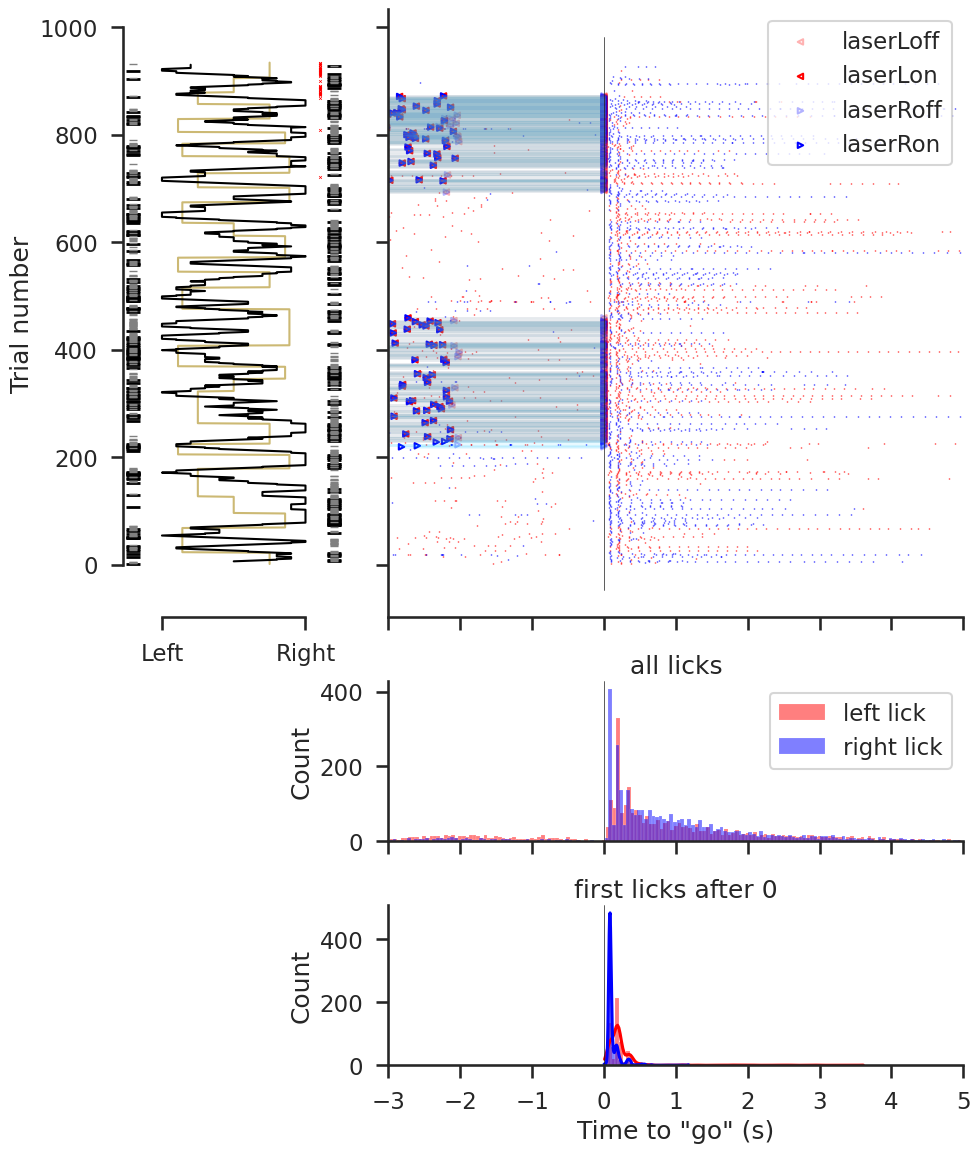

In [367]:
key = {'subject_id': 643252, 'session': 33}
foraging_plot.plot_lick_psth(key)

{'subject_id': 643252, 'session': 40}


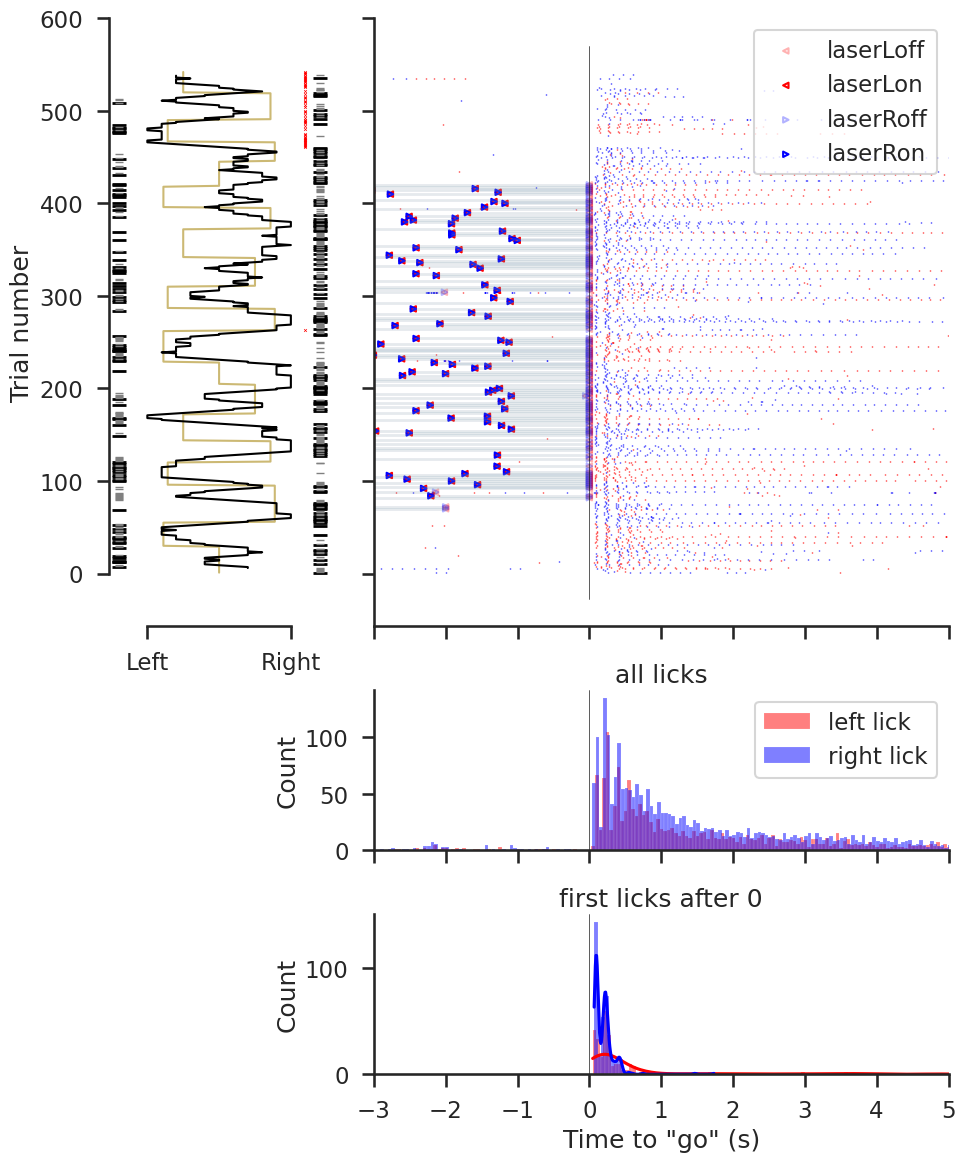

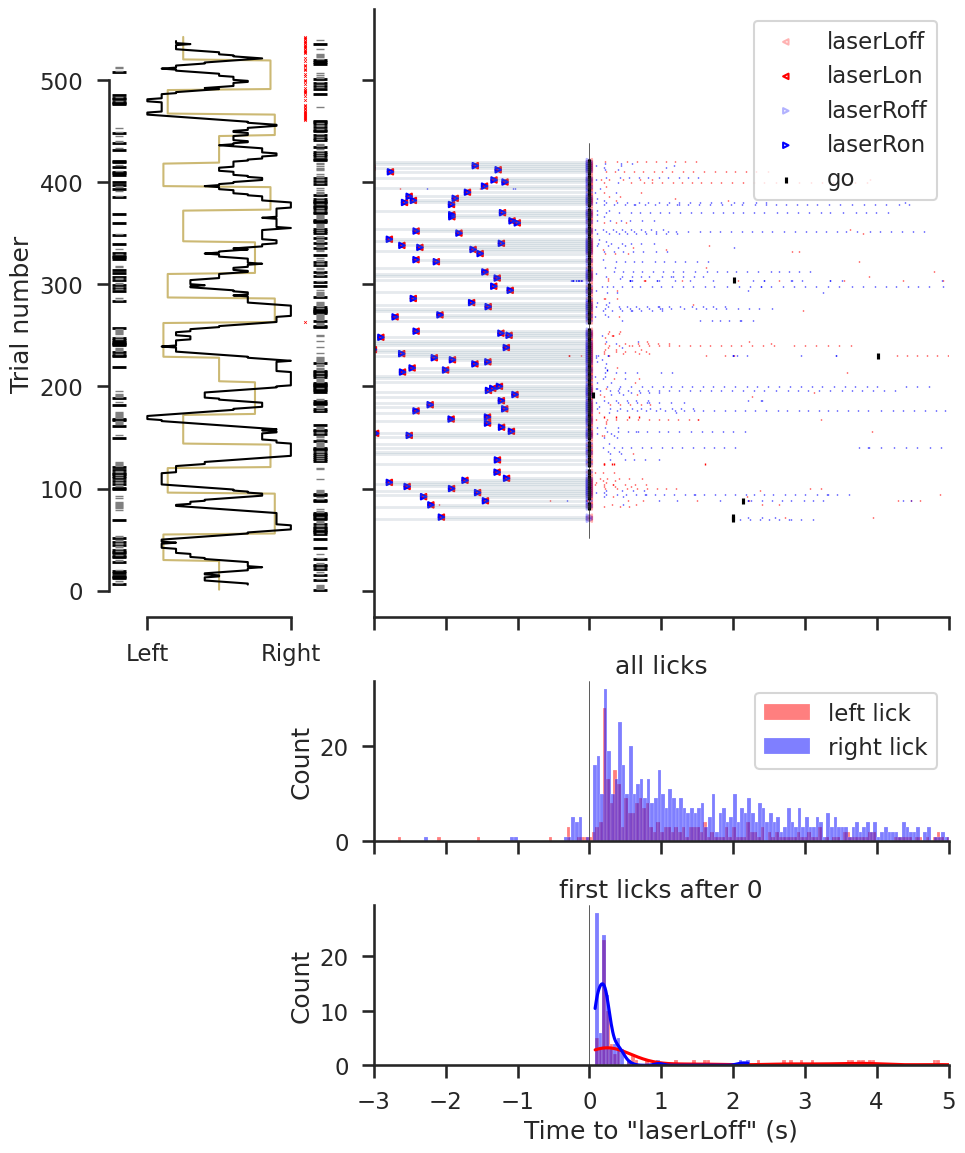

In [373]:
for key in q_xy_10.fetch('KEY', order_by='session')[-2:-1]:
    print(key)
    foraging_plot.plot_lick_psth(key)
    foraging_plot.plot_lick_psth(key, trial_event_to_align='laserLoff', other_trial_events={'laserLoff': ('None', '<'), 'laserLon': ('None', '<'), 'laserRoff': ('None', '>'), 'laserRon': ('None', '>'), 'go': ('black', '|')})

In [5]:
experiment.PhotostimForagingTrial.heading

# 
subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
trial                : smallint                     # trial number (1-based indexing)
photostim_event_id   : smallint                     # Same as PhotostimEvent (just in case there is one-to-many mapping)
---
side                 : smallint                     # 0: Left only, 1: Right only, 2: Bilateral
power                : decimal(8,3)                 # (mW) measured power of the sinusoid wave
on_to_go_cue         : decimal(8,4)                 # (s) from go cue of this trial
off_to_go_cue        : decimal(8,4)                 # (s) from go cue of this trial
duration             : decimal(8,4)                 # 
ramping_down         : decimal(8,4)                 # (s) ramping down duration
bpod_timer_align_to=null : varchar(30)                  # 
bpod_timer_offset=null : decimal(8,4)                 # From bpod protocol

In [2]:
from pipeline.model import descriptive_analysis
from pipeline.foraging_model import get_session_history

In [3]:
key = {'subject_id': 643252, 'session': 33}
c, r, _, p, _ = get_session_history(key, remove_ignored=True)
choice = c[0]
reward = np.sum(r, axis=0)

<AxesSubplot: title={'center': '10-fold CV, score $\\pm$ std = 0.755 $\\pm$ 0.061\nbest C = 0.0464'}, xlabel='Past trials', ylabel='Logistic regression coeffs'>

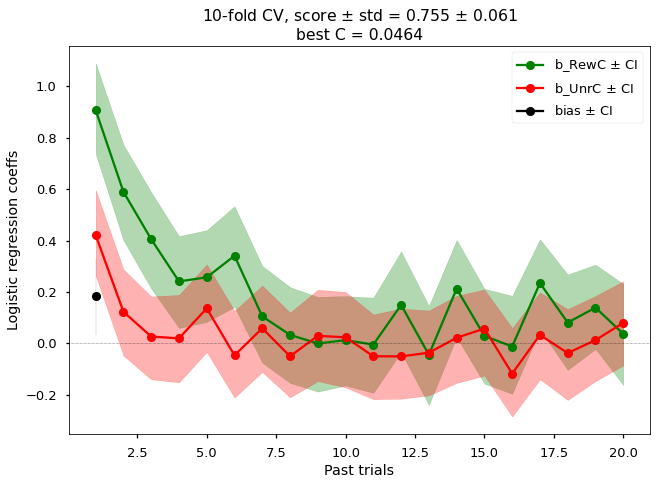

In [4]:
descriptive_analysis.do_logistic_regression_no_C(choice, reward)

Generated /root/capsule/data/report_stage/all_sessions/logistic_regression_hattori/HC16/HC16_20190911_1_logistic_regression_hattori.png


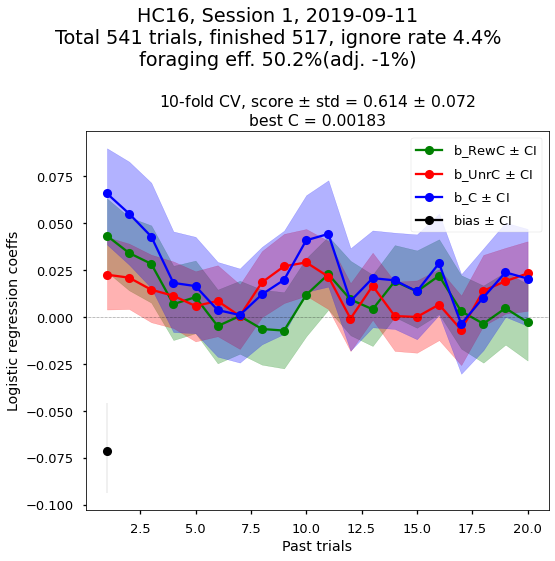

In [3]:
foraging_analysis_and_export.SessionLogisticRegressionHattori.populate(limit=1)

In [28]:
foraging_analysis_and_export.SessionLogisticRegressionHattori()

subject_id institution 6 digit animal ID,session session number,logistic_regression_hattori


[LogisticRegressionCV(Cs=20, cv=10, n_jobs=-1, solver='liblinear'),
 LogisticRegressionCV(Cs=20, cv=10, n_jobs=-1, solver='liblinear'),
 LogisticRegressionCV(Cs=20, cv=10, n_jobs=-1, solver='liblinear'),
 LogisticRegressionCV(Cs=20, cv=10, n_jobs=-1, solver='liblinear')]

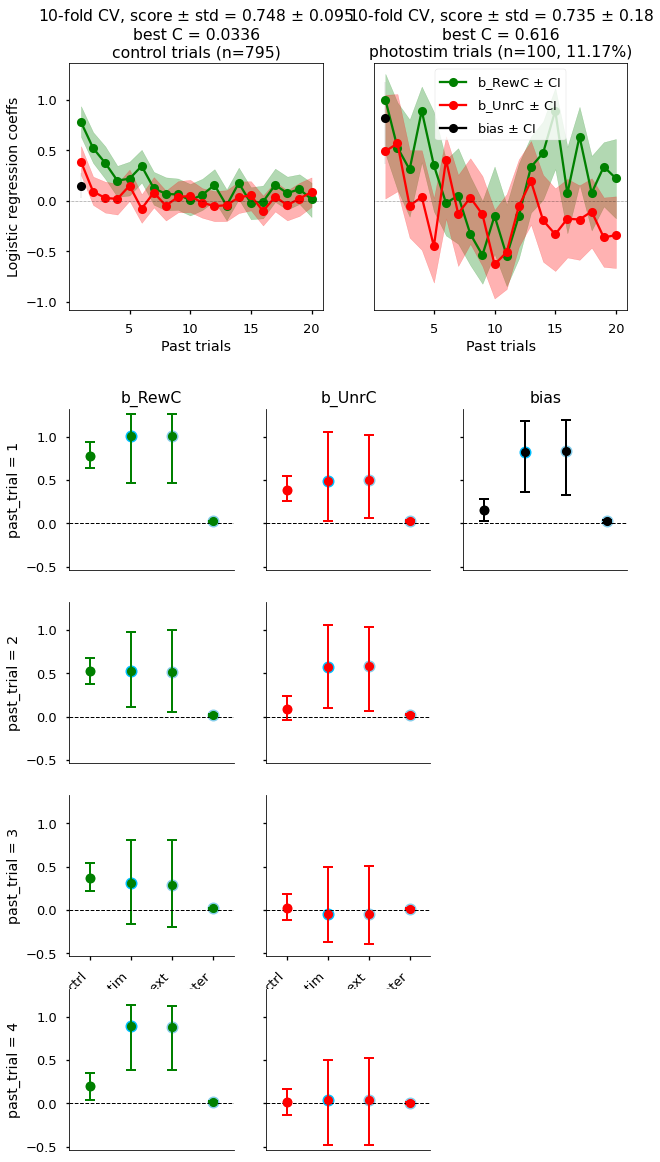

In [18]:
from pipeline.plot import foraging_model_plot
foraging_model_plot.plot_session_logistic(choice, reward, 
                                          model=descriptive_analysis.prepare_logistic_no_C,
                                          photostim_idx=np.r_[0:100])

In [130]:
len(choice)

753

All trials

Photostim trials

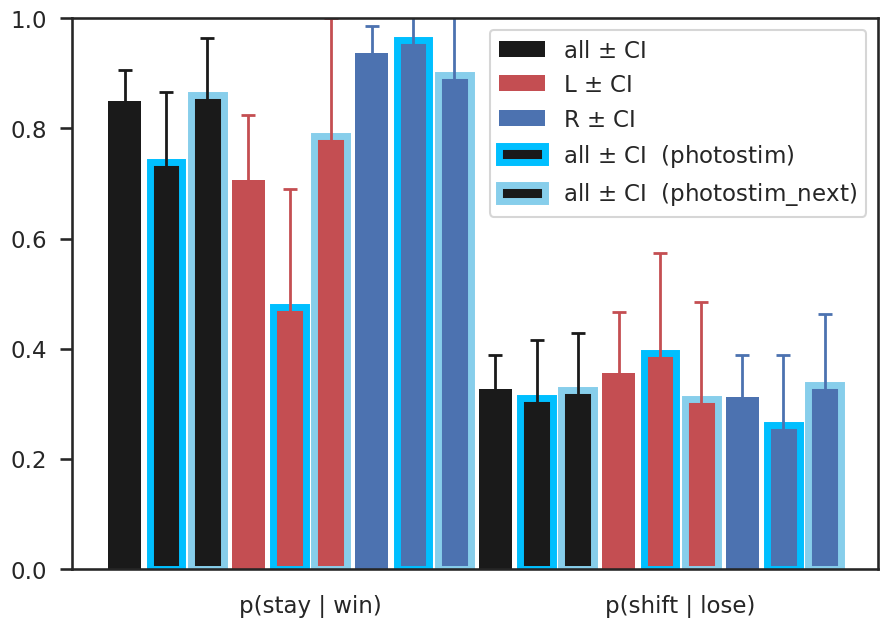

In [377]:
non_ignore_trial = (experiment.BehaviorTrial & key & 'outcome != "ignore"').fetch('trial')
photostim_trial = (experiment.PhotostimForagingTrial & (experiment.BehaviorTrial & key & 'outcome != "ignore"')).fetch('trial')

photostim_trial_in_non_ignore = np.nonzero(np.in1d(non_ignore_trial, photostim_trial))[0]   # np.searchsorted(non_ignore_trial, photostim_trial)
ctrl_trial_in_non_ignore = np.nonzero(~np.in1d(non_ignore_trial, photostim_trial))[0] 

p_wsls_ctrl = descriptive_analysis.win_stay_lose_shift(choice, reward, selected_trial_idx=ctrl_trial_in_non_ignore)
p_wsls_photostim = descriptive_analysis.win_stay_lose_shift(choice, reward, selected_trial_idx=photostim_trial_in_non_ignore)
p_wsls_photostim_next = descriptive_analysis.win_stay_lose_shift(choice, reward, selected_trial_idx=photostim_trial_in_non_ignore + 1)

ax = descriptive_analysis.plot_wsls([p_wsls_ctrl, p_wsls_photostim, p_wsls_photostim_next], edgecolors=['None', 'deepskyblue', 'skyblue'], labels=['', ' (photostim)', ' (photostim_next)'])
h, l = ax.get_legend_handles_labels()
l_to_show = np.r_[:4, 6]
ax.legend([h[i] for i in l_to_show], [l[i] for i in l_to_show])
# ax.set_ylim([0, 1.1])

In [6]:
from pipeline.plot import foraging_model_plot
foraging_model_plot.plot_session_logistic({'subject_id': 643252, 'session': 39})

TypeError: plot_session_logistic() missing 1 required positional argument: 'reward'

In [22]:
from pipeline import foraging_analysis_and_export
foraging_analysis_and_export.SessionLogisticRegression.delete()

[2023-02-17 19:01:38,533][INFO]: Deleting 305 rows from `map_v2_foraging_analysis_and_export`.`__session_logistic_regression`


Commit deletes? [yes, No]:  yes


Deletes committed.


305

SessionLogisticRegression:   0%|          | 0/84 [00:00<?, ?it/s]

Generated /home/jupyter/s3-drive-local/report/logistic_regression/HH16/HH16_20211210_19_logistic_regression.png


SessionLogisticRegression:   1%|          | 1/84 [00:03<05:04,  3.67s/it]

Generated /home/jupyter/s3-drive-local/report/logistic_regression/HH18/HH18_20211204_11_logistic_regression.png


SessionLogisticRegression:   2%|▏         | 2/84 [00:13<10:09,  7.43s/it]

Generated /home/jupyter/s3-drive-local/report/logistic_regression/HH18/HH18_20211205_12_logistic_regression.png


SessionLogisticRegression:   4%|▎         | 3/84 [00:21<10:06,  7.49s/it]

Generated /home/jupyter/s3-drive-local/report/logistic_regression/HH18/HH18_20211207_13_logistic_regression.png


SessionLogisticRegression:   5%|▍         | 4/84 [00:29<10:21,  7.76s/it]

Generated /home/jupyter/s3-drive-local/report/logistic_regression/HH18/HH18_20211208_14_logistic_regression.png


SessionLogisticRegression:   6%|▌         | 5/84 [00:41<10:52,  8.26s/it]


KeyboardInterrupt: 

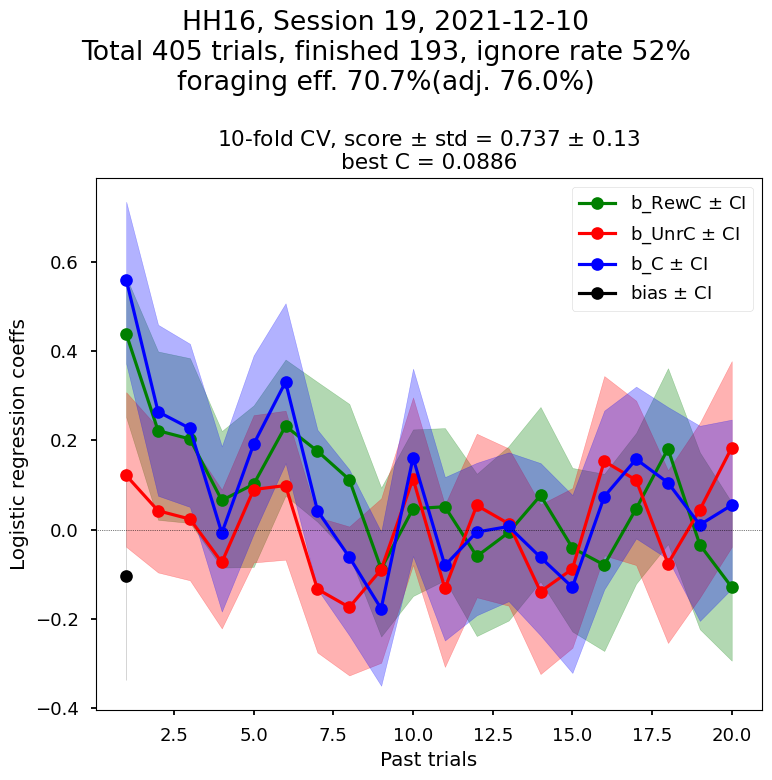

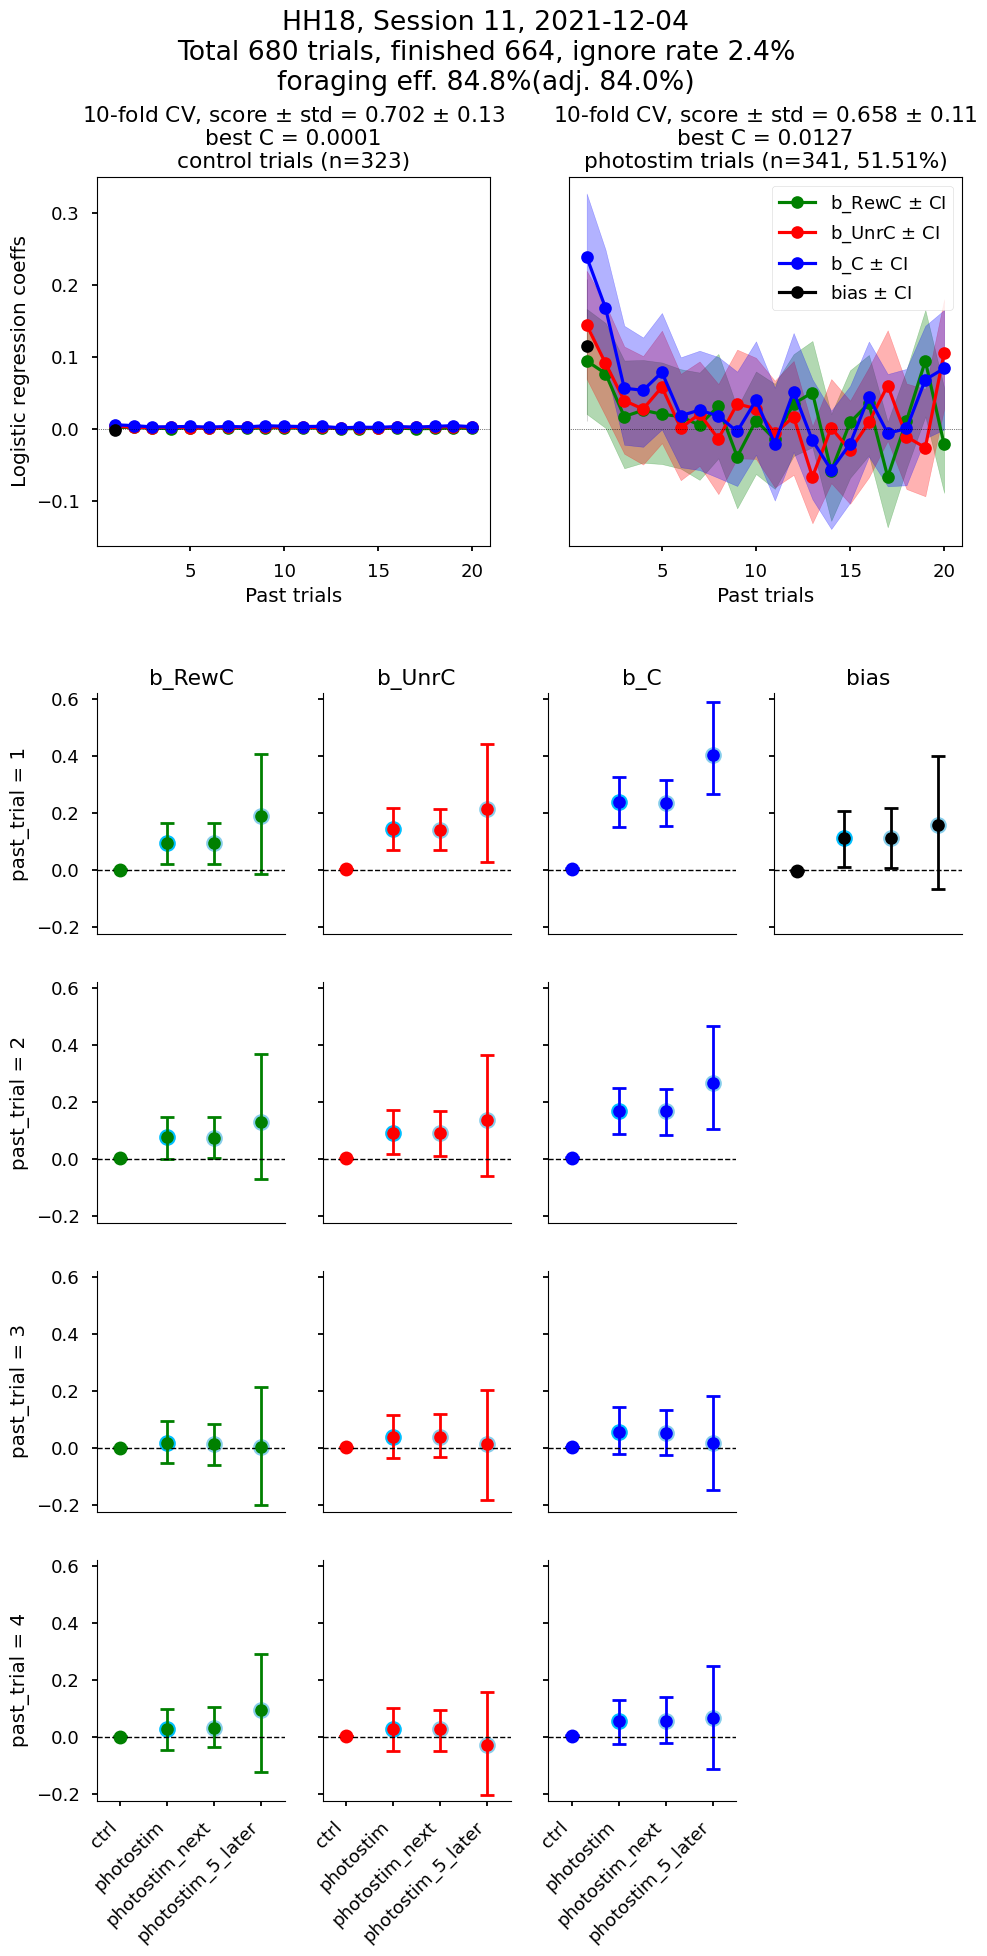

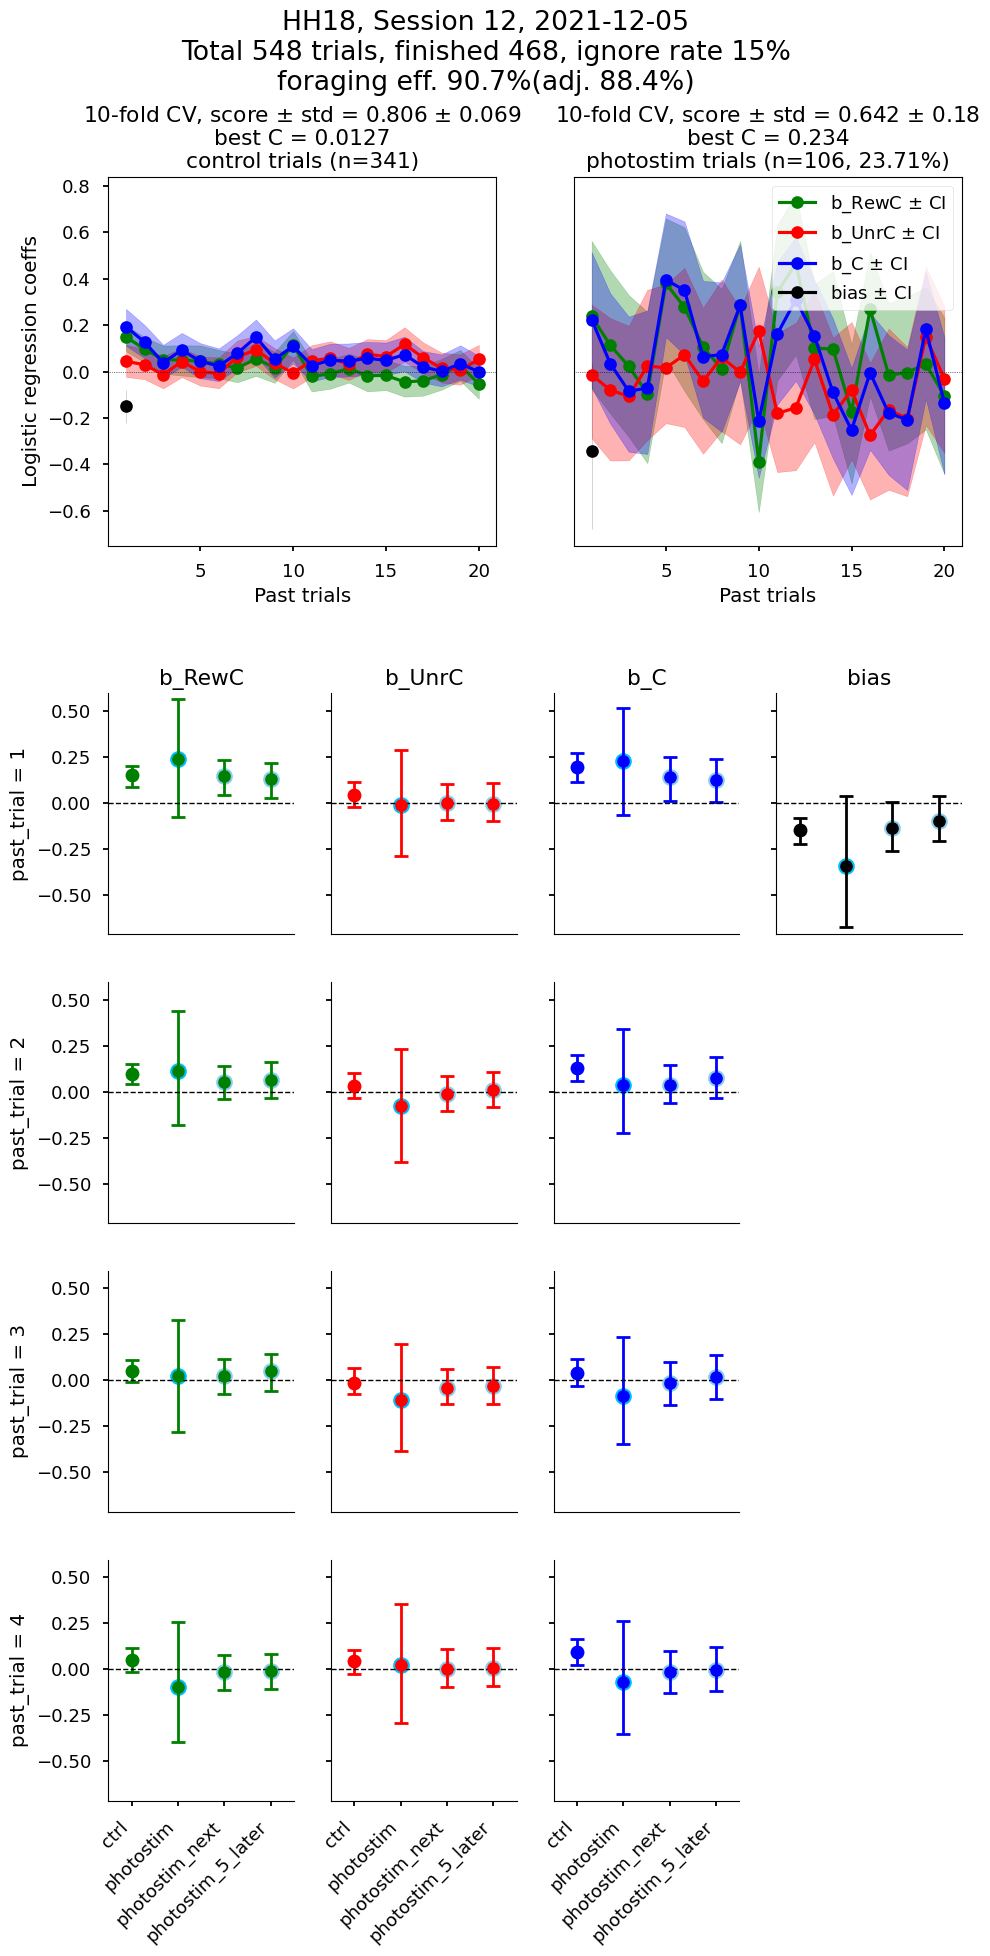

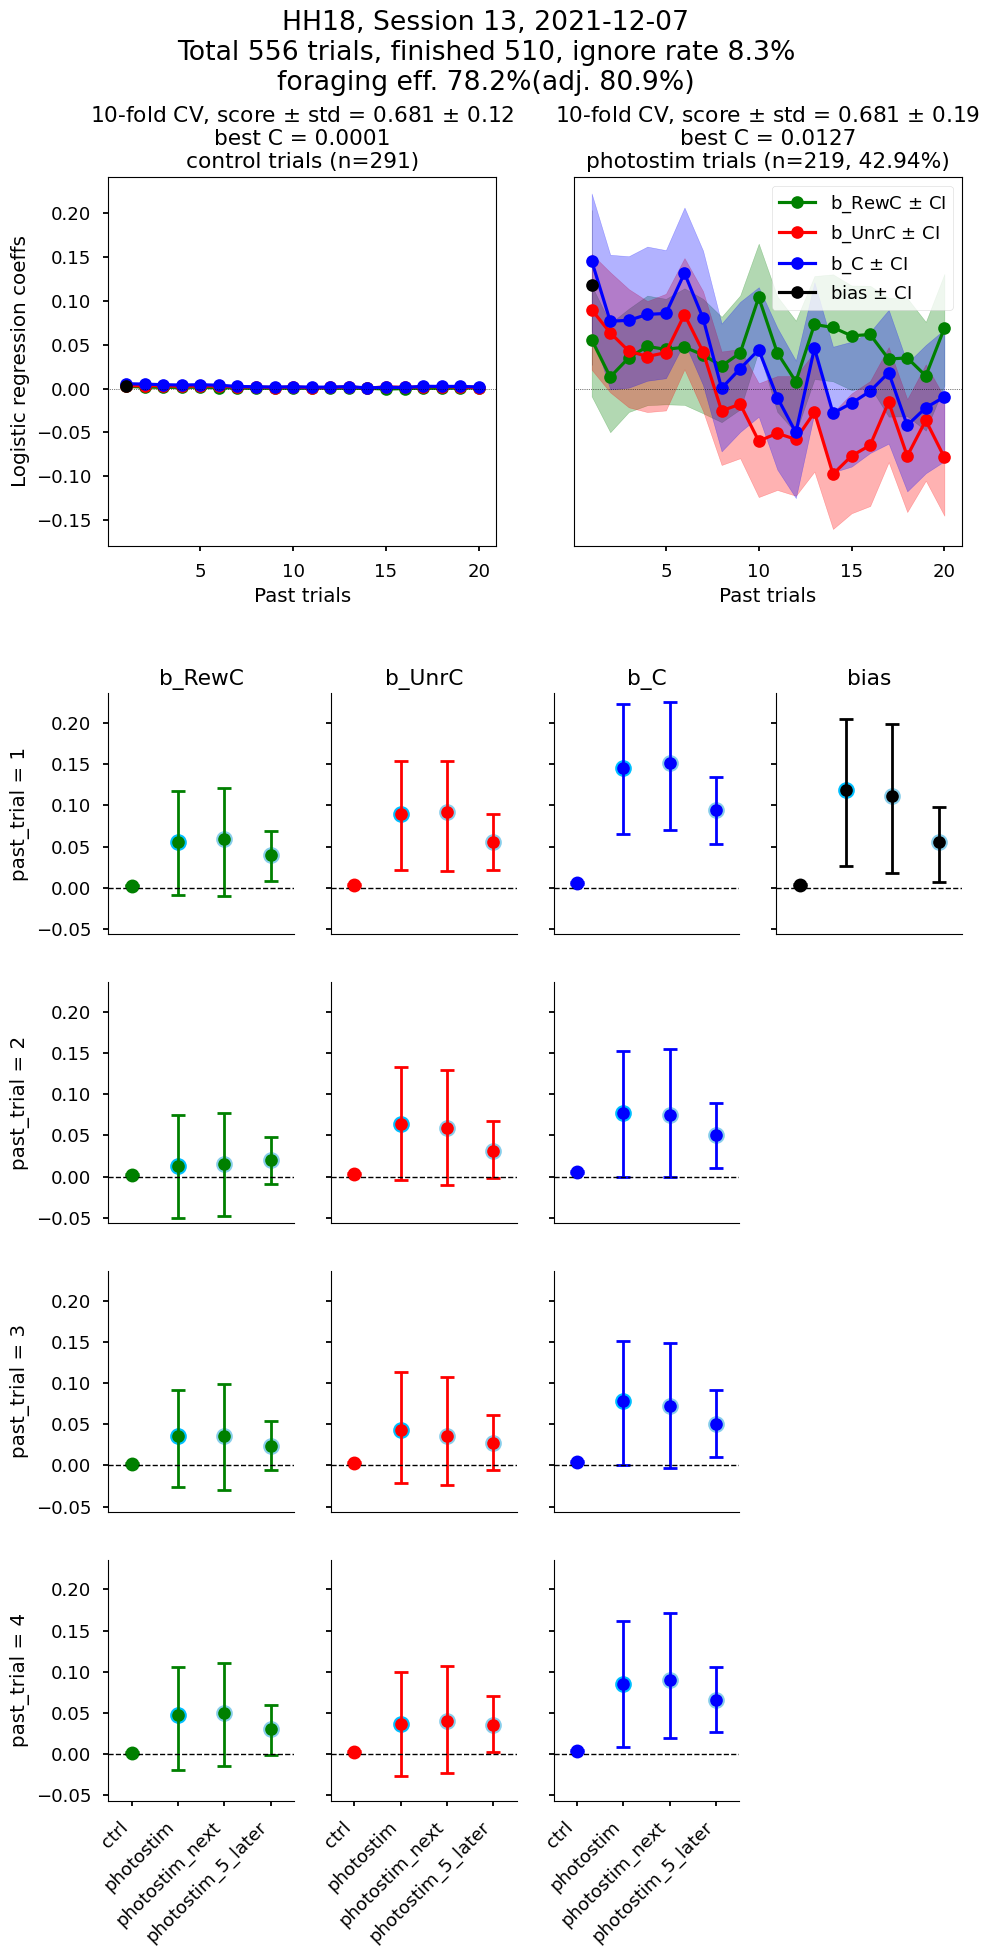

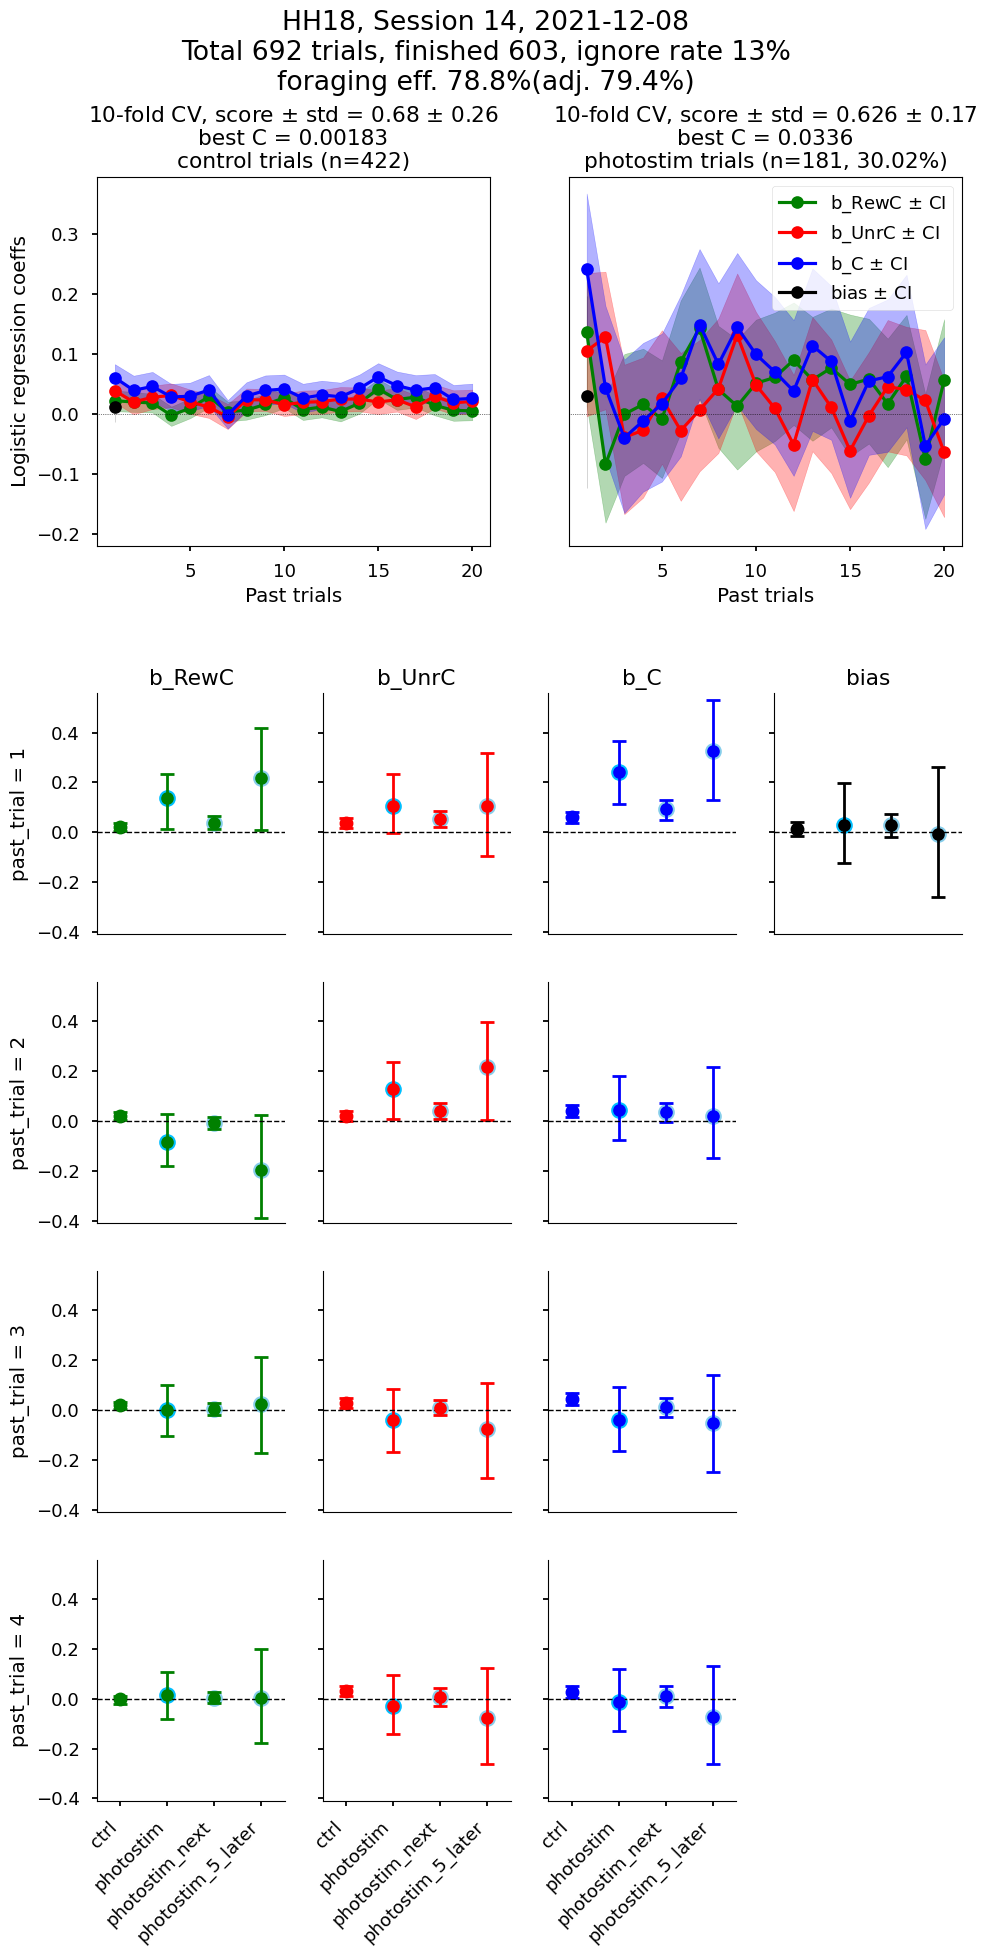

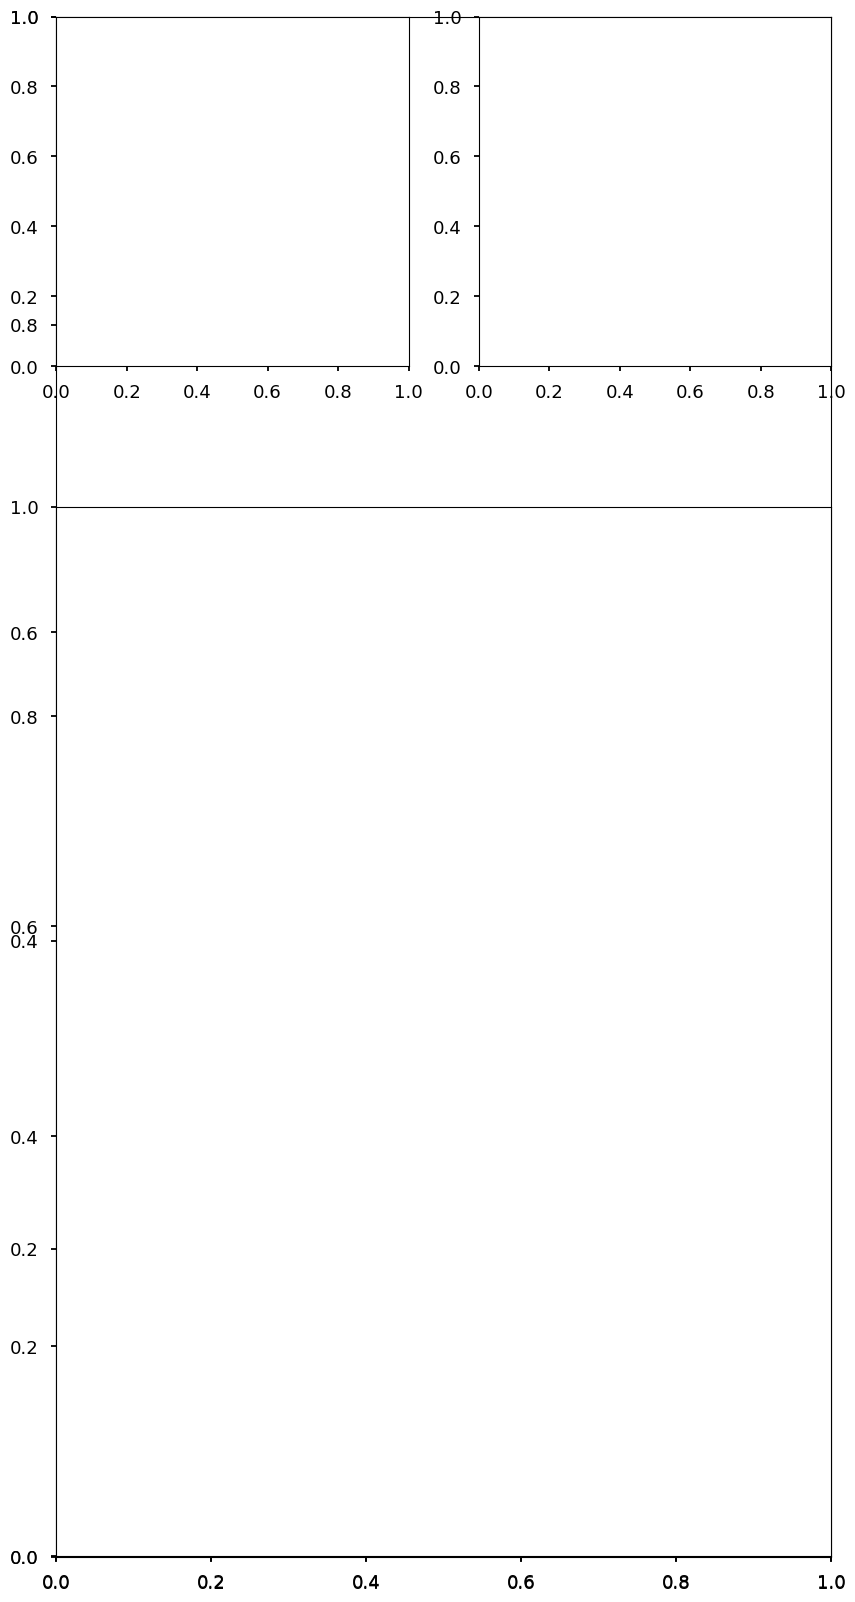

In [5]:
foraging_analysis_and_export.SessionLogisticRegression.populate(display_progress=True)

Generated /home/jupyter/s3-drive-local/report/all_sessions/logistic_regression/HH16/HH16_20211210_19_logistic_regression.png
Generated /home/jupyter/s3-drive-local/report/all_sessions/logistic_regression/HH18/HH18_20211204_11_logistic_regression.png


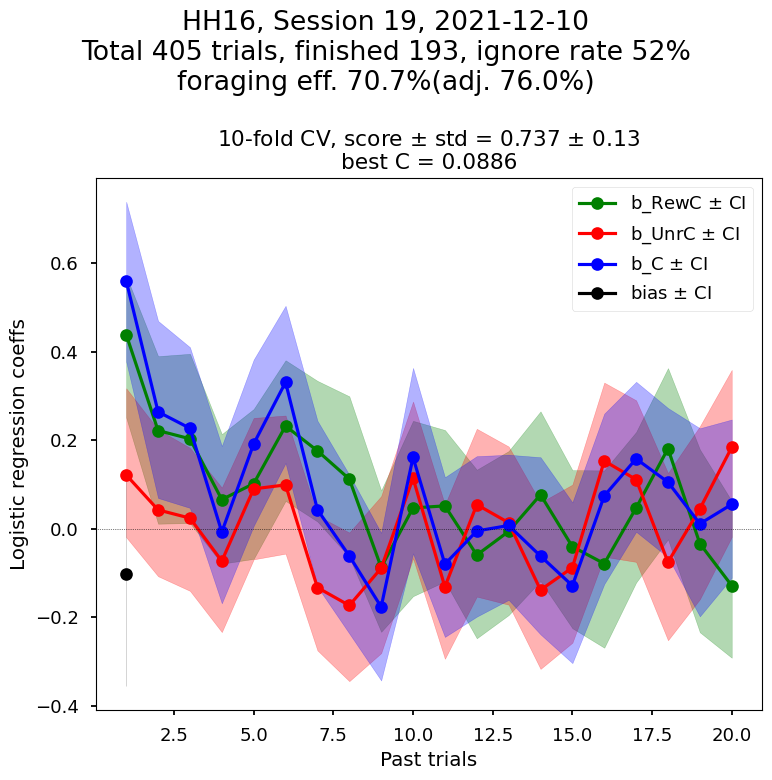

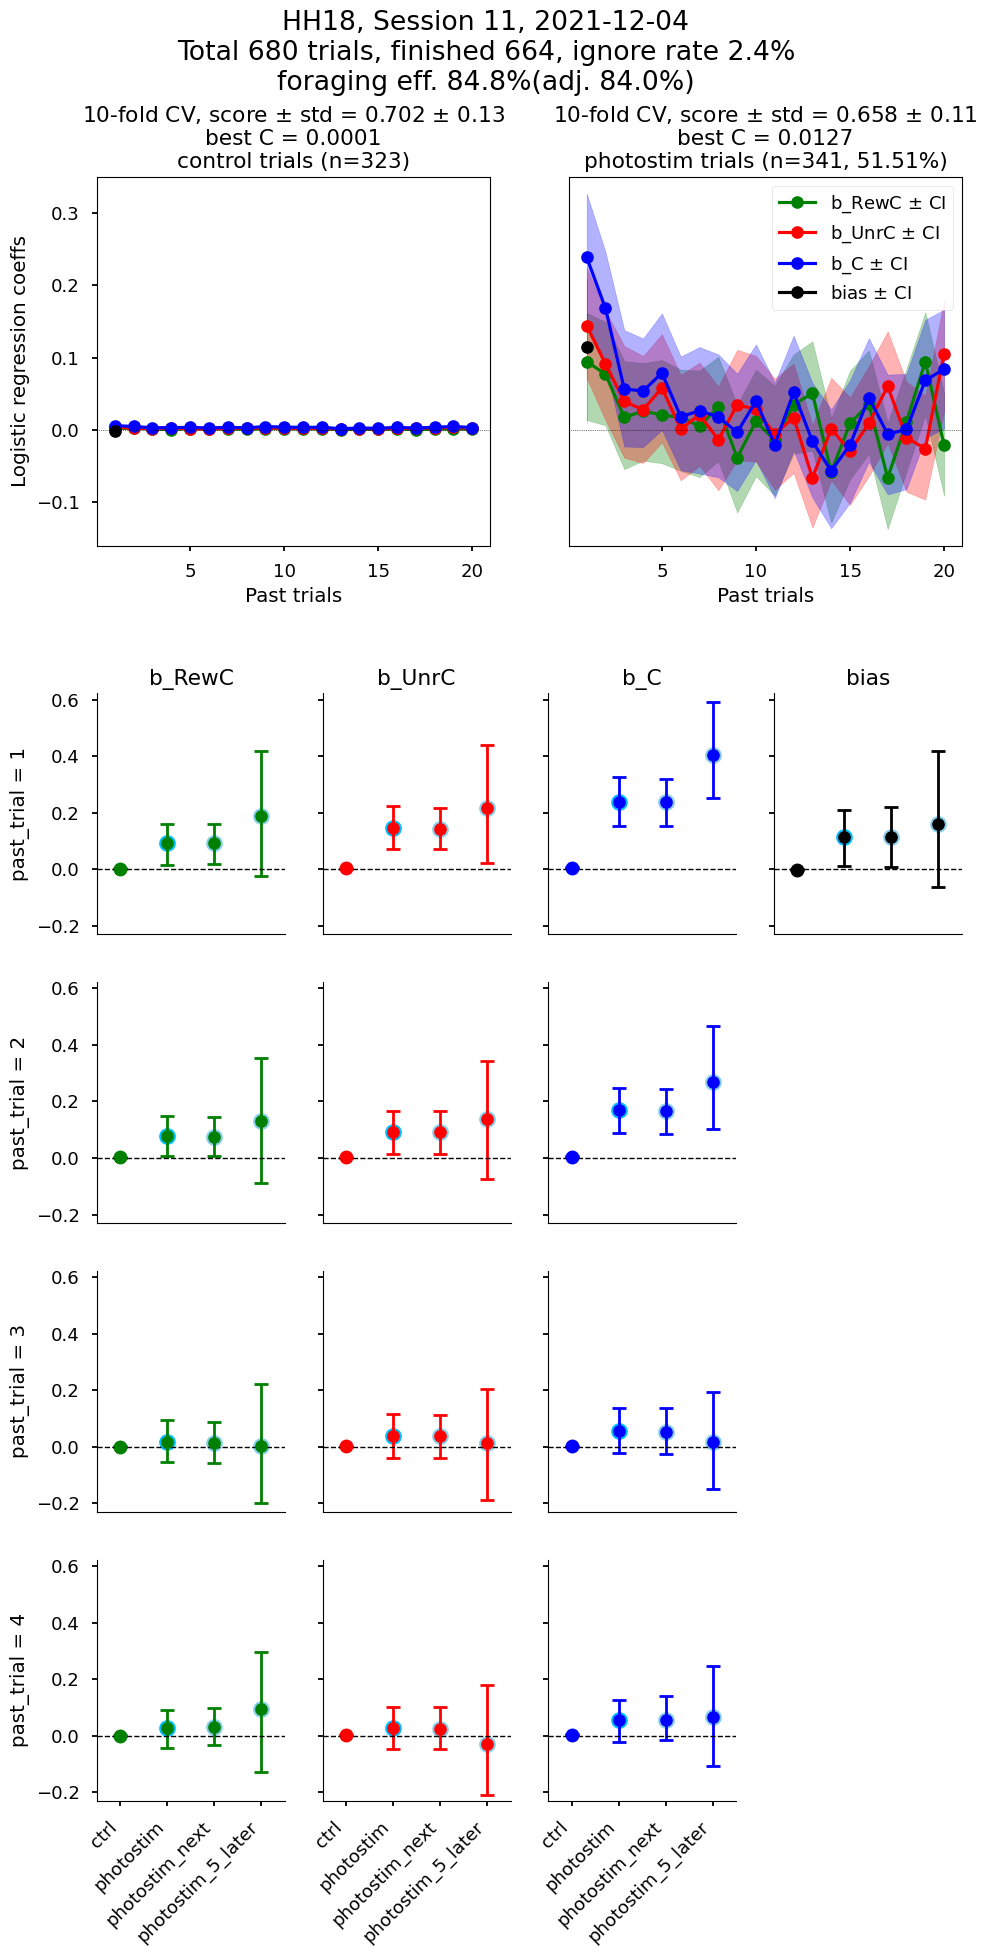

In [14]:
foraging_analysis_and_export.SessionLogisticRegression.populate(limit=2)

In [23]:
foraging_analysis_and_export.SessionLogisticRegressionReport.delete()

[2023-02-17 19:01:50,999][INFO]: Deleting 0 rows from `map_v2_foraging_analysis_and_export`.`__session_logistic_regression_report`


Nothing to delete.


0

In [24]:
(foraging_analysis_and_export.schema.external['report_store'] & 'filepath LIKE "%logistic%"').delete(delete_external_files=True)

0it [00:00, ?it/s]


[]

## Group analysis for photostim

In [3]:
photostim_behavior = photostim_behavior.set_index(['h2o', 'session'])


In [26]:
photostim_behavior

subject_id session_date photostim_behav photostim_NI
h2o   session                                                      
HH16  19           494691   2021-12-10             yes           no
HH18  21           494694   2021-12-16             yes          yes
      20           494694   2021-12-15             yes          yes
      19           494694   2021-12-14             yes          yes
      18           494694   2021-12-13             yes          yes
...                   ...          ...             ...          ...
XY_09 41           646196   2023-02-01             yes           no
      40           646196   2023-01-31             yes           no
      39           646196   2023-01-30             yes           no
      38           646196   2023-01-27             yes           no
      37           646196   2023-01-26             yes           no

[84 rows x 4 columns]

In [4]:
(foraging_analysis_and_export.SessionLogisticRegression.key_source - foraging_analysis_and_export.SessionLogisticRegression)* lab.WaterRestriction

subject_id institution 6 digit animal ID,session session number,water_restriction_number WR number,cage_number,wr_start_date,wr_start_weight
643774,19,XY_12,0,2022-11-11,25.400
643774,27,XY_12,0,2022-11-11,25.400
646196,43,XY_09,0,2022-10-11,27.800
656057,15,XY_16,0,2023-01-25,23.400
656058,14,XY_19,0,2023-01-25,20.200


In [29]:
foraging_analysis_and_export.schema.jobs.delete()

In [7]:
cache_folder = '~/s3-drive/report/st_cache/'

In [5]:

betas
betas.to_pickle(cache_folder + 'photostim_logistic_regression.pkl')

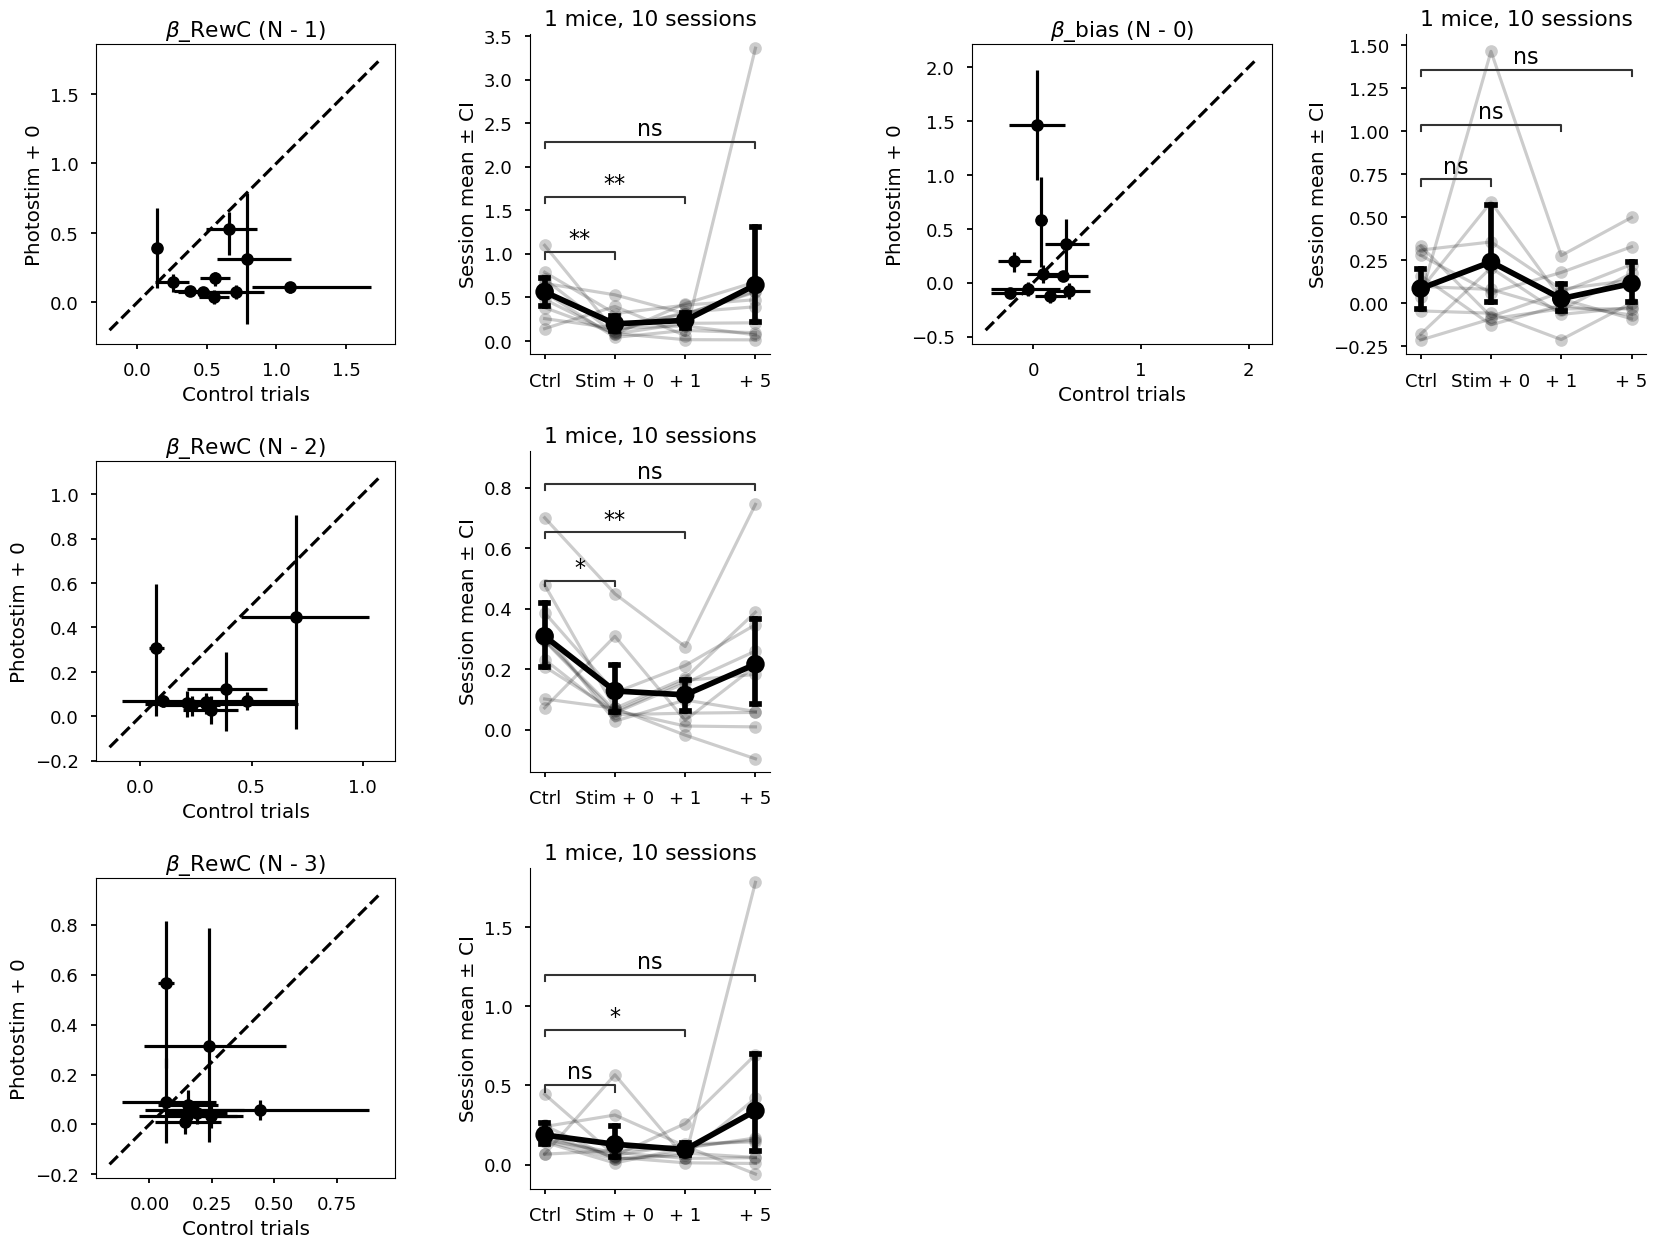

In [4]:
def _draw_variable_trial_back(df, beta_name, trials_back, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(7, 3), constrained_layout=True) 
        
    gs = ax._subplotspec.subgridspec(1, 2, wspace=0.5, width_ratios=(1, 0.8))
    axes = []
    axes.append(ax.get_figure().add_subplot(gs[0]))
    axes.append(ax.get_figure().add_subplot(gs[1]))
        
    plot_range = (-1.0, 1.0) if beta_name == 'bias' else (0, 1.5)

    # df_beta = foraging_analysis_and_export.SessionLogisticRegression & (lab.WaterRestriction & 'water_restriction_number = "XY_10"') & 'beta = "C"' & 'trials_back = 1' & 'session > 32'
    # df_beta = pd.DataFrame(df_beta.fetch())

    q_para = f'beta == "{beta_name}" and trials_back == {trials_back}'
    df_beta = df.query(q_para)
    var_name = rf'$\beta$_{beta_name} (N - {trials_back})'

    # --- 2-d plot with session-wise CI ---
    axes[0].errorbar(x=df_beta.query("trial_group == 'ctrl'")['mean'], 
                 y=df_beta.query("trial_group == 'photostim'")['mean'],
                 xerr=np.array(list(df_beta.query("trial_group == 'ctrl'")['error_bar'])).T,
                 yerr=np.array(list(df_beta.query("trial_group == 'photostim'")['error_bar'])).T,
                 marker='o', color='k', linestyle='')

    plot_range = [min(axes[0].get_xlim()[0], axes[0].get_ylim()[0]),
                  max(axes[0].get_xlim()[1], axes[0].get_ylim()[1])]
    axes[0].plot(plot_range, plot_range, 'k--')
    
    axes[0].set(#xlim=plot_range, ylim=plot_range, 
                title=var_name, 
                xlabel='Control trials', ylabel='Photostim + 0')
    axes[0].set_aspect('equal', 'box')


    #--- Wilcoxon plot ---
    # with sns.plotting_context("notebook", font_scale=1):
    plotting_parameters = {
    'data': df_beta,
    'x': 'trial_group',
    'y': 'mean',
    }

    axes[1].plot(np.arange(len(df_beta['trial_group'].unique())), 
                 np.matrix([df_beta.query(f'trial_group == "{group}"')['mean']
                            for group in df_beta['trial_group'].unique()]),
                 'ok-', alpha=0.2)
    sns.pointplot(ax=axes[1], 
                  **plotting_parameters,
                  errorbar=('ci', 95), capsize=.1,
                  color='k')
    
    # Add stat annotations
    pairs = [('ctrl', 'photostim'), 
             ('ctrl', 'photostim_next'), 
             ('ctrl', 'photostim_next5')]
    pvalues = [scipy.stats.wilcoxon(x=df_beta.query(f"trial_group == '{x}'")['mean'], 
                                    y=df_beta.query(f"trial_group == '{y}'")['mean']).pvalue
               for x, y in pairs]
    formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    annotator = Annotator(axes[1], pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.configure(#text_format='simple', 
        verbose=False)
    # annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()
    
    axes[1].set_xticklabels(['Ctrl', 'Stim + 0', '+ 1', '+ 5'], rotation=0, ha='center')
    axes[1].set(#ylim=plot_range, title=var_name, 
                xlabel='', ylabel='Session mean $\pm$ CI')
    axes[1].spines[['right', 'top']].set_visible(False)
    axes[1].set_title(f"{len(df_beta['h2o'].unique())} mice, {len(df_beta['session'].unique())} sessions")
        
    ax.remove()
    
    return axes


df_all = pd.DataFrame((foraging_analysis_and_export.SessionLogisticRegression * lab.WaterRestriction.proj(h2o='water_restriction_number') & 'trials_back <= 10').fetch())
df_all['error_bar'] = [[x, y] for x, y in zip(df_all['mean'] - df_all.lower_ci,  df_all.upper_ci - df_all['mean'])]
df_all['h2o_session'] = df_all[['h2o', 'session']].astype(str).apply('_'.join, axis=1)


q_sessions = 'h2o == "XY_10" and session > 33'
df_all.query(q_sessions + ' & ' + 'trial_group != "all_no_stim"', inplace=True)

beta_names = ['RewC', 'UnrC', 'C']
past_trials_to_plot = (1, 2, 3)

fig, axes = plt.subplots(len(past_trials_to_plot), len(beta_names) + 1, 
                         figsize=(10 * (len(beta_names) + 1), 5 * len(past_trials_to_plot)), constrained_layout=False,
                         gridspec_kw=dict(hspace=0.3, wspace=0.3))
axes = np.atleast_2d(axes)

for i, trials_back in enumerate(past_trials_to_plot):
    for j, name in enumerate(beta_names):        
        _draw_variable_trial_back(df_all, name, trials_back, ax=axes[i, j])
_draw_variable_trial_back(df_all, 'bias', 0, ax=axes[0, j + 1])

for i in range(1, len(past_trials_to_plot)): axes[i, -1].remove()


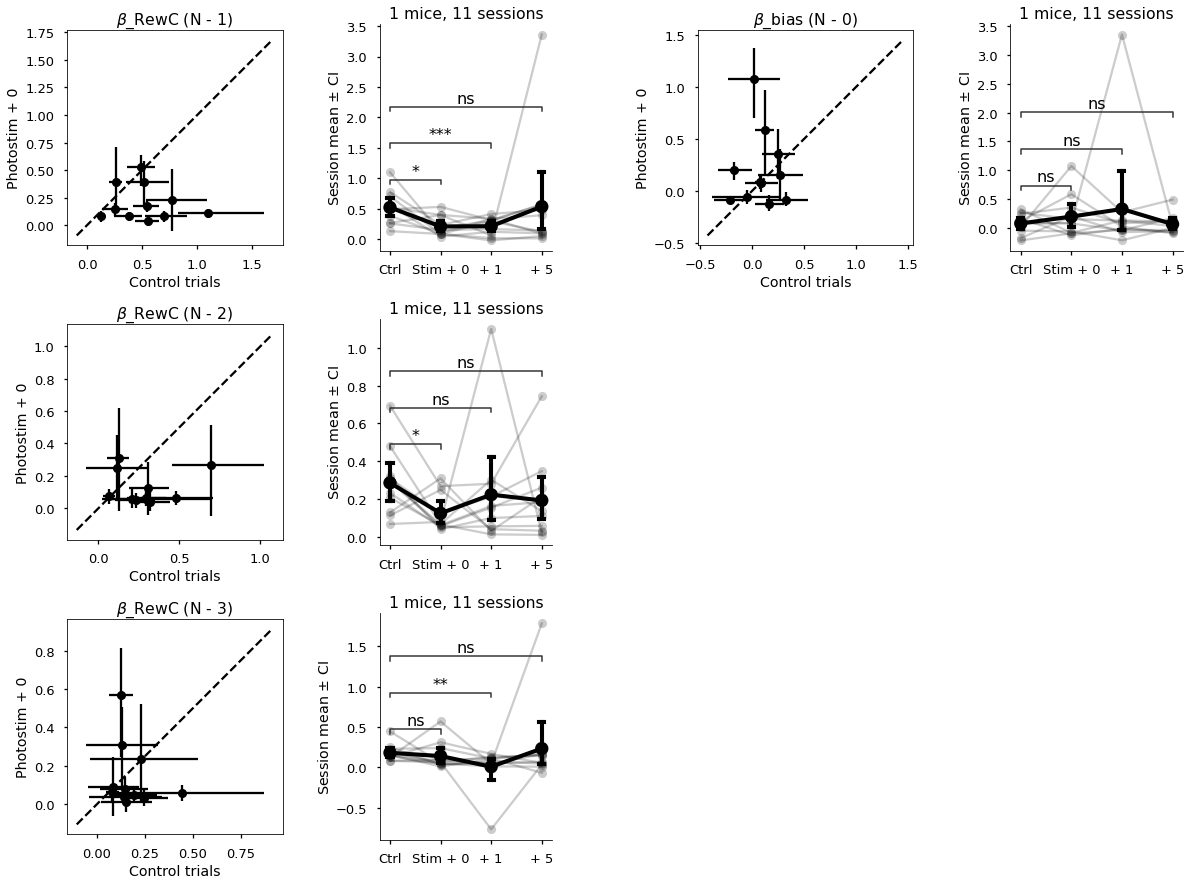

In [2]:
def _draw_variable_trial_back(df, beta_name, trials_back, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(7, 3), constrained_layout=True) 
        
    gs = ax._subplotspec.subgridspec(1, 2, wspace=0.5, width_ratios=(1, 0.8))
    axes = []
    axes.append(ax.get_figure().add_subplot(gs[0]))
    axes.append(ax.get_figure().add_subplot(gs[1]))
        
    plot_range = (-1.0, 1.0) if beta_name == 'bias' else (0, 1.5)

    # df_beta = foraging_analysis_and_export.SessionLogisticRegression & (lab.WaterRestriction & 'water_restriction_number = "XY_10"') & 'beta = "C"' & 'trials_back = 1' & 'session > 32'
    # df_beta = pd.DataFrame(df_beta.fetch())

    q_para = f'beta == "{beta_name}" and trials_back == {trials_back}'
    df_beta = df.query(q_para)
    var_name = rf'$\beta$_{beta_name} (N - {trials_back})'

    # --- 2-d plot with session-wise CI ---
    axes[0].errorbar(x=df_beta.query("trial_group == 'ctrl'")['mean'], 
                 y=df_beta.query("trial_group == 'photostim'")['mean'],
                 xerr=np.array(list(df_beta.query("trial_group == 'ctrl'")['error_bar'])).T,
                 yerr=np.array(list(df_beta.query("trial_group == 'photostim'")['error_bar'])).T,
                 marker='o', color='k', linestyle='')

    plot_range = [min(axes[0].get_xlim()[0], axes[0].get_ylim()[0]),
                  max(axes[0].get_xlim()[1], axes[0].get_ylim()[1])]
    axes[0].plot(plot_range, plot_range, 'k--')
    
    axes[0].set(#xlim=plot_range, ylim=plot_range, 
                title=var_name, 
                xlabel='Control trials', ylabel='Photostim + 0')
    axes[0].set_aspect('equal', 'box')


    #--- Wilcoxon plot ---
    # with sns.plotting_context("notebook", font_scale=1):
    plotting_parameters = {
    'data': df_beta,
    'x': 'trial_group',
    'y': 'mean',
    }

    axes[1].plot(np.arange(len(df_beta['trial_group'].unique())), 
                 np.matrix([df_beta.query(f'trial_group == "{group}"')['mean']
                            for group in df_beta['trial_group'].unique()]),
                 'ok-', alpha=0.2)
    sns.pointplot(ax=axes[1], 
                  **plotting_parameters,
                  errorbar=('ci', 95), capsize=.1,
                  color='k')
    
    # Add stat annotations
    pairs = [('ctrl', 'photostim'), 
             ('ctrl', 'photostim_next'), 
             ('ctrl', 'photostim_next5')]
    pvalues = [scipy.stats.wilcoxon(x=df_beta.query(f"trial_group == '{x}'")['mean'], 
                                    y=df_beta.query(f"trial_group == '{y}'")['mean']).pvalue
               for x, y in pairs]
    formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    annotator = Annotator(axes[1], pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.configure(#text_format='simple', 
        verbose=False)
    # annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()
    
    axes[1].set_xticklabels(['Ctrl', 'Stim + 0', '+ 1', '+ 5'], rotation=0, ha='center')
    axes[1].set(#ylim=plot_range, title=var_name, 
                xlabel='', ylabel='Session mean $\pm$ CI')
    axes[1].spines[['right', 'top']].set_visible(False)
    axes[1].set_title(f"{len(df_beta['h2o'].unique())} mice, {len(df_beta['session'].unique())} sessions")
        
    ax.remove()
    
    return axes


df_all = pd.DataFrame((foraging_analysis_and_export.SessionLogisticRegression * lab.WaterRestriction.proj(h2o='water_restriction_number') & 'trials_back <= 10').fetch())
df_all['error_bar'] = [[x, y] for x, y in zip(df_all['mean'] - df_all.lower_ci,  df_all.upper_ci - df_all['mean'])]
df_all['h2o_session'] = df_all[['h2o', 'session']].astype(str).apply('_'.join, axis=1)


q_sessions = 'h2o == "XY_10" and session > 33'
df_all.query(q_sessions + ' & ' + 'trial_group != "all_no_stim"', inplace=True)

beta_names = ['RewC',]#, 'UnrC', 'C']
past_trials_to_plot = (1, 2, 3)

fig, axes = plt.subplots(len(past_trials_to_plot), len(beta_names) + 1, 
                         figsize=(10 * (len(beta_names) + 1), 5 * len(past_trials_to_plot)), constrained_layout=False,
                         gridspec_kw=dict(hspace=0.3, wspace=0.3))
axes = np.atleast_2d(axes)

for i, trials_back in enumerate(past_trials_to_plot):
    for j, name in enumerate(beta_names):        
        _draw_variable_trial_back(df_all, name, trials_back, ax=axes[i, j])
_draw_variable_trial_back(df_all, 'bias', 0, ax=axes[0, j + 1])

for i in range(1, len(past_trials_to_plot)): axes[i, -1].remove()


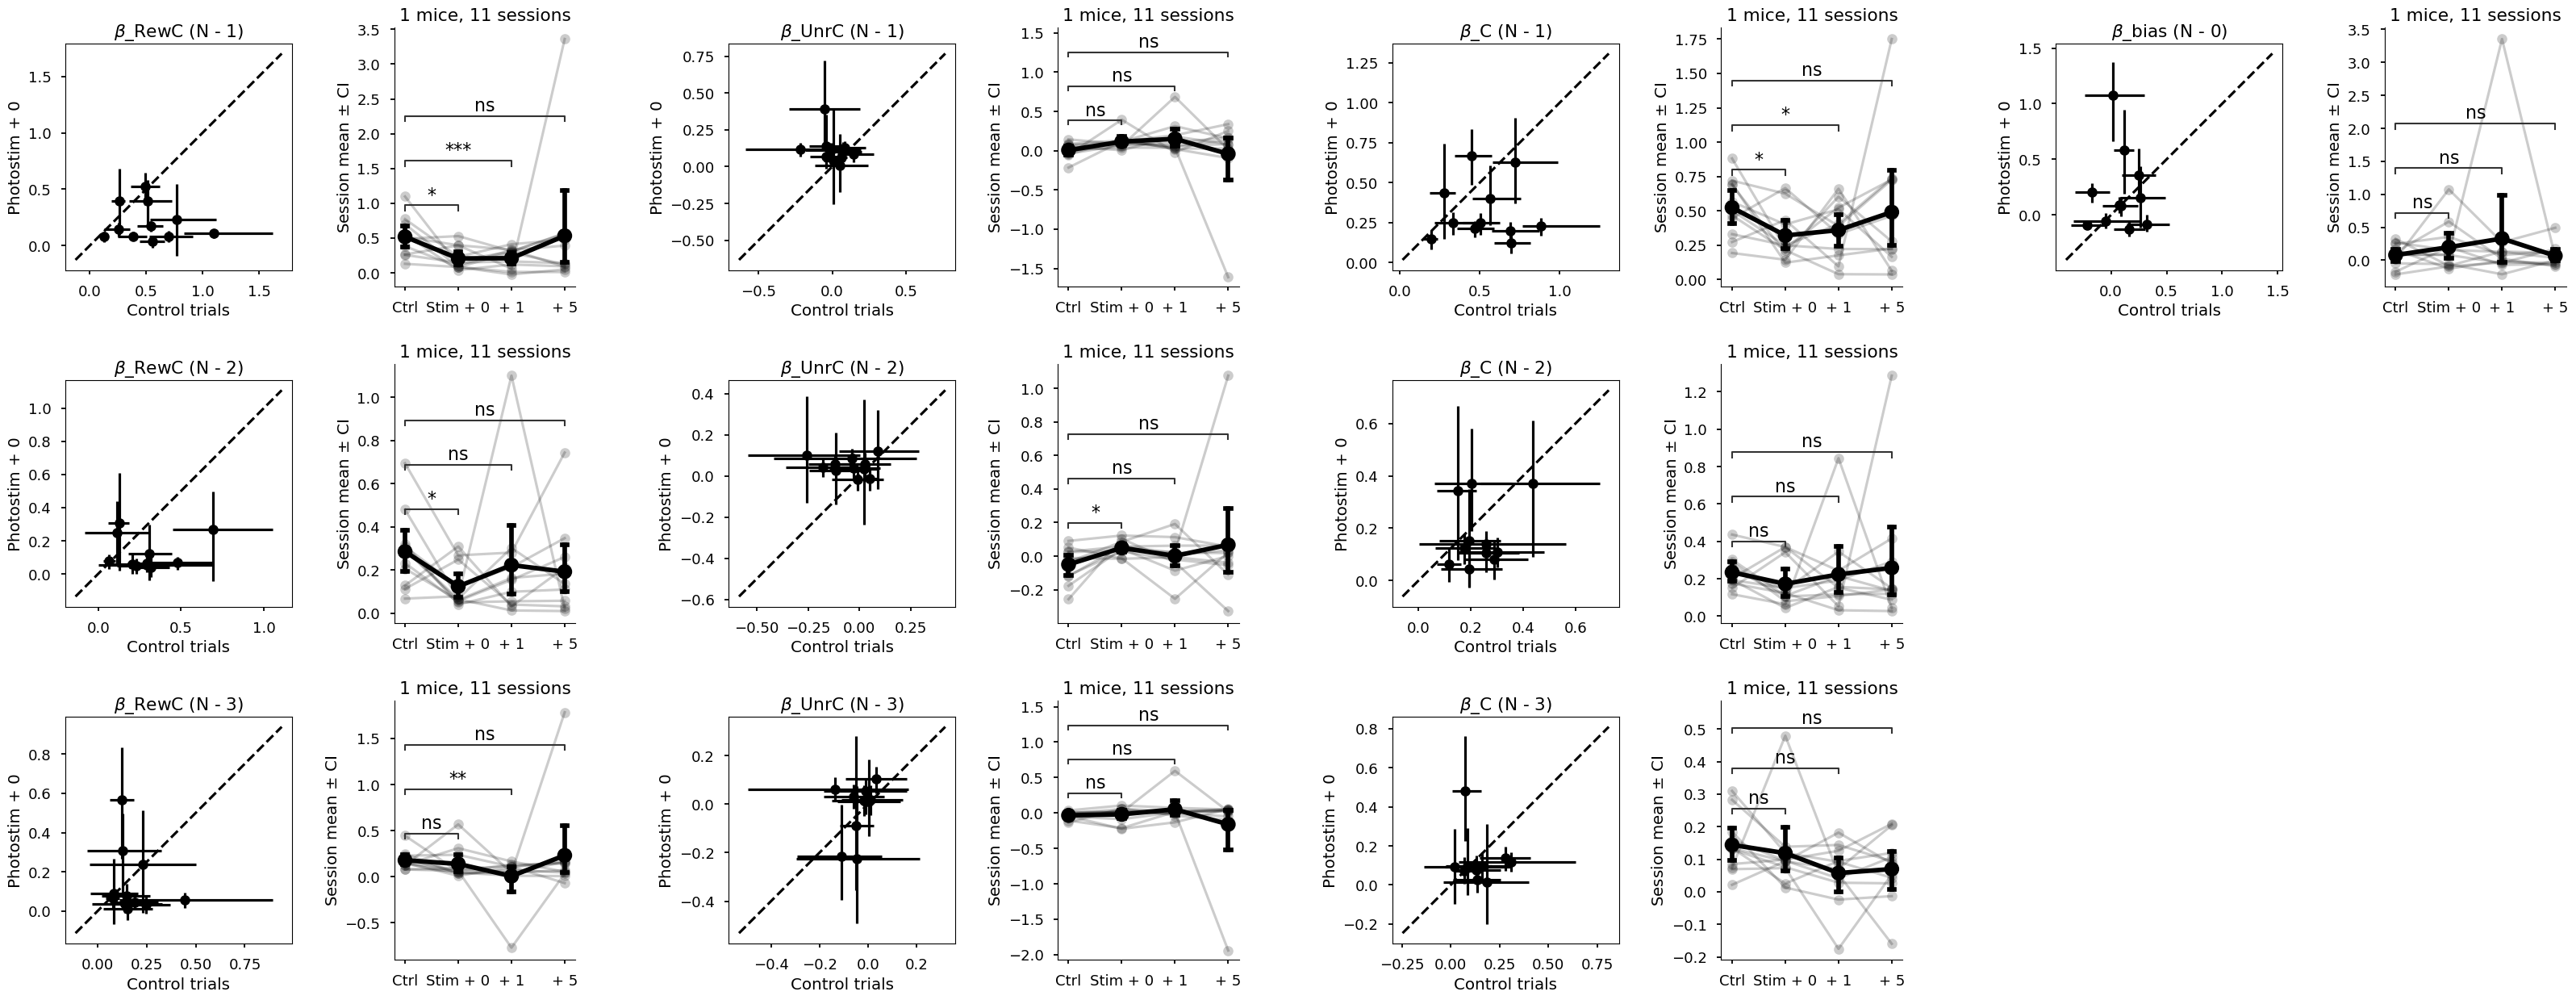

In [190]:
def _draw_variable_trial_back(df, beta_name, trials_back, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(7, 3), constrained_layout=True) 
        
    gs = ax._subplotspec.subgridspec(1, 2, wspace=0.5, width_ratios=(1, 0.8))
    axes = []
    axes.append(ax.get_figure().add_subplot(gs[0]))
    axes.append(ax.get_figure().add_subplot(gs[1]))
        
    plot_range = (-1.0, 1.0) if beta_name == 'bias' else (0, 1.5)

    # df_beta = foraging_analysis_and_export.SessionLogisticRegression & (lab.WaterRestriction & 'water_restriction_number = "XY_10"') & 'beta = "C"' & 'trials_back = 1' & 'session > 32'
    # df_beta = pd.DataFrame(df_beta.fetch())

    q_para = f'beta == "{beta_name}" and trials_back == {trials_back}'
    df_beta = df.query(q_para)
    var_name = rf'$\beta$_{beta_name} (N - {trials_back})'

    # --- 2-d plot with session-wise CI ---
    axes[0].errorbar(x=df_beta.query("trial_group == 'ctrl'")['mean'], 
                 y=df_beta.query("trial_group == 'photostim'")['mean'],
                 xerr=np.array(list(df_beta.query("trial_group == 'ctrl'")['error_bar'])).T,
                 yerr=np.array(list(df_beta.query("trial_group == 'photostim'")['error_bar'])).T,
                 marker='o', color='k', linestyle='')

    plot_range = [min(axes[0].get_xlim()[0], axes[0].get_ylim()[0]),
                  max(axes[0].get_xlim()[1], axes[0].get_ylim()[1])]
    axes[0].plot(plot_range, plot_range, 'k--')
    
    axes[0].set(#xlim=plot_range, ylim=plot_range, 
                title=var_name, 
                xlabel='Control trials', ylabel='Photostim + 0')
    axes[0].set_aspect('equal', 'box')


    #--- Wilcoxon plot ---
    # with sns.plotting_context("notebook", font_scale=1):
    plotting_parameters = {
    'data': df_beta,
    'x': 'trial_group',
    'y': 'mean',
    }

    axes[1].plot(np.arange(len(df_beta['trial_group'].unique())), 
                 np.matrix([df_beta.query(f'trial_group == "{group}"')['mean']
                            for group in df_beta['trial_group'].unique()]),
                 'ok-', alpha=0.2)
    sns.pointplot(ax=axes[1], 
                  **plotting_parameters,
                  errorbar=('ci', 95), capsize=.1,
                  color='k')
    
    # Add stat annotations
    pairs = [('ctrl', 'photostim'), 
             ('ctrl', 'photostim_next'), 
             ('ctrl', 'photostim_next5')]
    pvalues = [scipy.stats.wilcoxon(x=df_beta.query(f"trial_group == '{x}'")['mean'], 
                                    y=df_beta.query(f"trial_group == '{y}'")['mean']).pvalue
               for x, y in pairs]
    formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    annotator = Annotator(axes[1], pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.configure(#text_format='simple', 
        verbose=False)
    # annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()
    
    axes[1].set_xticklabels(['Ctrl', 'Stim + 0', '+ 1', '+ 5'], rotation=0, ha='center')
    axes[1].set(#ylim=plot_range, title=var_name, 
                xlabel='', ylabel='Session mean $\pm$ CI')
    axes[1].spines[['right', 'top']].set_visible(False)
    axes[1].set_title(f"{len(df_beta['h2o'].unique())} mice, {len(df_beta['session'].unique())} sessions")
        
    ax.remove()
    
    return axes


df_all = pd.DataFrame((foraging_analysis_and_export.SessionLogisticRegression * lab.WaterRestriction.proj(h2o='water_restriction_number') & 'trials_back <= 10').fetch())
df_all['error_bar'] = [[x, y] for x, y in zip(df_all['mean'] - df_all.lower_ci,  df_all.upper_ci - df_all['mean'])]
df_all['h2o_session'] = df_all[['h2o', 'session']].astype(str).apply('_'.join, axis=1)


q_sessions = 'h2o == "XY_10" and session > 33'
df_all.query(q_sessions + ' & ' + 'trial_group != "all_no_stim"', inplace=True)

beta_names = ['RewC', 'UnrC', 'C']
past_trials_to_plot = (1, 2, 3)

fig, axes = plt.subplots(len(past_trials_to_plot), len(beta_names) + 1, 
                         figsize=(10 * (len(beta_names) + 1), 5 * len(past_trials_to_plot)), constrained_layout=False,
                         gridspec_kw=dict(hspace=0.3, wspace=0.3))
axes = np.atleast_2d(axes)

for i, trials_back in enumerate(past_trials_to_plot):
    for j, name in enumerate(beta_names):        
        _draw_variable_trial_back(df_all, name, trials_back, ax=axes[i, j])
_draw_variable_trial_back(df_all, 'bias', 0, ax=axes[0, j + 1])

for i in range(1, len(past_trials_to_plot)): axes[i, -1].remove()


In [7]:
experiment.Session & (lab.WaterRestriction & 'water_restriction_number = "FOR10"') & 'session=142'

subject_id institution 6 digit animal ID,session session number,session_date,session_time,username,rig
457498,142,2019-10-24,22:00:34,Tina,Training-Tower-1


In [12]:
from pipeline.export import to_s3
to_s3.export_df_foraging_sessions()

file exported to Han/ephys/report/st_cache/df_sessions.pkl, size = 0.7782402038574219 MB, df_length = 2868


,subject_id,session,session_date,h2o,finished,foraging_eff,photostim,task,ephys_ins,histology,...,mean_reward_sum,mean_reward_contrast,reward_rate,miss_rate,ignore_rate,block_length,not_pretrain,valid_trial_start,valid_trial_end,valid_ratio
0,447921,38,2019-11-01,HC16,384,0.9571,,coupled_block_baiting,0,,...,0.450,5.61306,0.2897,0.5365,0.1738,51.7778,1,1,453,0.972103
1,447921,37,2019-10-31,HC16,270,0.8898,,coupled_block_baiting,0,,...,0.450,5.18258,0.2842,0.4424,0.2735,53.2857,1,1,346,0.927614
2,447921,36,2019-10-30,HC16,799,0.8933,,coupled_block_baiting,0,,...,0.450,5.61280,0.3552,0.6133,0.0315,43.4211,1,7,825,0.992727
3,447921,35,2019-10-29,HC16,566,0.6404,,coupled_block_baiting,0,,...,0.450,6.25251,0.2316,0.6729,0.0955,71.0000,1,1,638,0.998435
4,447921,34,2019-10-28,HC16,710,0.8007,,coupled_block_baiting,0,,...,0.450,5.87316,0.3160,0.6307,0.0533,53.5714,1,1,750,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,661100,5,2023-02-13,XY_21,459,0.7692,,coupled_block_baiting,0,,...,0.922,4.53340,0.5328,0.4440,0.0233,3.1959,1,1,454,0.959831
2865,661100,4,2023-02-10,XY_21,402,0.7928,,coupled_block_baiting,0,,...,1.000,4.00000,0.6511,0.3391,0.0098,50.8750,1,2,407,0.997543
2866,661100,3,2023-02-09,XY_21,427,0.6800,,coupled_block_baiting,0,,...,0.450,4.68897,0.2951,0.6433,0.0616,42.8182,1,15,471,0.970276
2867,661100,2,2023-02-08,XY_21,375,0.5935,,coupled_block_baiting,0,,...,0.800,7.00347,0.3881,0.4840,0.1279,24.6842,1,7,469,0.987207
